## Load Model and Evaluate Performance - Final Model

This Notebook evaluates the performance of the model on the test data. It calculates the 
- UAUC
- UAUC@M
- Recall@M
- Precision@M
- and further analysis

to compare the results to other training runs and baseline models

In [3]:
import numpy as np
import tensorflow as tf
from numpy.random import seed
from tensorflow import set_random_seed
seed(1)
set_random_seed(1)

from keras import initializers
from keras.regularizers import l2
from keras.models import Model
from keras.layers import Embedding, Input, Dense, merge, Flatten, concatenate, multiply, dot, Reshape, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.optimizers import Adagrad, Adam, SGD, RMSprop
import keras.callbacks
from time import time
import pdb
from scipy import sparse
import sqlalchemy as db
from sqlalchemy import create_engine
import psycopg2
import sqlite3

In [4]:
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K

In [5]:
import pandas as pd

In [6]:
# DATABASE_URI = ###
# engine = create_engine(DATABASE_URI)
engine = sqlite3.connect('data/db.db',check_same_thread=False)

In [7]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score
import matplotlib.pyplot as plt

In [8]:
import evaluate

In [1]:
pre_tr = "data/models/training/"

In [ ]:
pre_ev = "data/models/evaluation/"

### Model

In [11]:
import Hybrid_NeuMF

In [12]:
# Parameters
# Model
# MLP
layers = [128,64,32,16] #[378,162,42,14]
reg_layers = [0.001, 0.001, 0.001, 0.001] #[0.04,0.0001,0.01,0.01] #
# MF
reg_mf = 0.001 #0.0003 
#num_negatives = args.num_neg
learning_rate = 0.001

In [13]:
model = Hybrid_NeuMF.get_model(layers, reg_layers, reg_mf)

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
weights_path = pre_tr + "4_1_leaky_relu_low_reg_weights.h5"


In [18]:
model.load_weights(weights_path)

# Evaluation

## General Auroc

Calculate the general Roc of across all users - same as selection criteria for best model

In [13]:
query = ('''SELECT  [index], userid
            FROM    target_testing_enc''')
test_data = pd.read_sql(query, engine)

In [14]:
test_list = test_data['index'].values.tolist()

In [15]:
len(test_list)

1251313

In [16]:
y_all = []
predict_all = []
for batches in range(0, len(test_list), 50000):
    indeci = tuple(test_list[batches:batches+50000])
    query_v = f"""
        SELECT * FROM target_testing_enc where [index] IN {indeci}
    """
    data = pd.read_sql_query(query_v, engine)
    data_p = evaluate.transform_log(data, 200)
    # select truth and make prediction
    y_true = data.pick.values.flatten().tolist()
    y_score = model.predict(x = data_p).flatten().tolist()
    y_all.append(y_true)
    predict_all.append(y_score)
# flatten all results
flat_list_y = [item for sublist in y_all for item in sublist]
flat_list_predict = [item for sublist in predict_all for item in sublist]
# make arrays
y_array = np.array(flat_list_y, ndmin = 2).reshape(-1,1)
pred_array = np.array(flat_list_predict, ndmin =2).reshape(-1,1)

In [17]:
flat_list_predict

[0.4237225651741028,
 0.23989611864089966,
 0.08876383304595947,
 0.29077842831611633,
 0.18718469142913818,
 0.19317862391471863,
 0.3687571883201599,
 0.25895529985427856,
 0.19872888922691345,
 0.2561191916465759,
 0.2438620626926422,
 0.2038680613040924,
 0.027973830699920654,
 0.2945929765701294,
 0.32343584299087524,
 0.3314560353755951,
 0.2198309600353241,
 0.2958192825317383,
 0.3331128656864166,
 0.10489597916603088,
 0.3287845253944397,
 0.14668893814086914,
 0.3155859112739563,
 0.3531990349292755,
 0.380190372467041,
 0.3547917604446411,
 0.41121706366539,
 0.3770095407962799,
 0.23137420415878296,
 0.2389795184135437,
 0.14450260996818542,
 0.1655464768409729,
 0.18302148580551147,
 0.30251163244247437,
 0.23367750644683838,
 0.2169933021068573,
 0.45633065700531006,
 0.30834048986434937,
 0.20467787981033325,
 0.26603999733924866,
 0.11601752042770386,
 0.3123394846916199,
 0.16661393642425537,
 0.25891247391700745,
 0.06174477934837341,
 0.22773286700248718,
 0.21697458

In [18]:
len(flat_list_predict)

1251313

In [19]:
len(flat_list_y)

1251313

In [20]:
test_roc = roc_auc_score(y_array, pred_array)

In [21]:
test_roc

0.6510268052026963

### Results

In [22]:
results = pd.DataFrame({'index': test_list,
                        'userid': test_data.userid.values.tolist(),
                       'y_true': flat_list_y,
                       'y_pred': flat_list_predict})

In [23]:
results.head()

,index,userid,y_true,y_pred
0,118334,793955,0.0,0.423723
1,118335,1630984,1.0,0.239896
2,118336,1678111,0.0,0.088764
3,118337,793955,0.0,0.290778
4,118338,1677245,0.0,0.187185


In [33]:
np.mean(results.y_true)

0.2854074080585753

### Filter user with 67488 clicks - userID : 

In [25]:
results.groupby('userid').count().sort_values(by = 'index', ascending = False)

,index,y_true,y_pred
userid,,,
1657316,67488,67488,67488
1621085,6389,6389,6389
1576169,5695,5695,5695
902588,5469,5469,5469
1683120,3890,3890,3890
...,...,...,...
1628616,1,1,1
715226,1,1,1
1673131,1,1,1


In [26]:
results_filtered = results[results.userid != '1657316']

In [27]:
roc_auc_score(results_filtered.y_true, results_filtered.y_pred)

0.6626163763730015

the difference between filtered and not-filtered AUC is only 1.2 percent-points

In [28]:
results.to_pickle(pre_ev+'05_1_test_results.pkl')

## AUC Curve

In [20]:
results = pd.read_pickle(pre_ev+'05_1_test_results.pkl')

In [22]:
import scikitplot as skplt
import matplotlib as plt

In [24]:
results.head()

,index,userid,y_true,y_pred
0,118334,793955,0.0,0.423723
1,118335,1630984,1.0,0.239896
2,118336,1678111,0.0,0.088764
3,118337,793955,0.0,0.290778
4,118338,1677245,0.0,0.187185


In [27]:
results['y_pred_n'] = 1 - results.y_pred

In [28]:
results.sample(5)

,index,userid,y_true,y_pred,y_pred_n
1095381,1213968,1684524,1.0,0.223215,0.776785
1168963,35895,722837,0.0,0.315810,0.684190
974455,1093028,1531654,1.0,0.324391,0.675609
298067,416477,1680721,0.0,0.192942,0.807058
58473,176816,880398,1.0,0.347322,0.652678


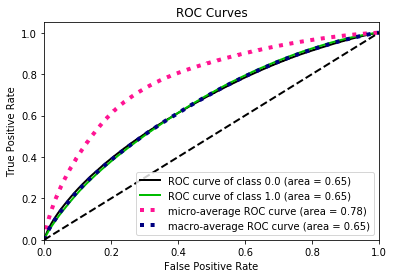

In [31]:
skplt.metrics.plot_roc(results.y_true.values, results[['y_pred_n', 'y_pred']].values)

## Per User Metrics

In [32]:
results.head()

,index,userid,y_true,y_pred,y_pred_n
0,118334,793955,0.0,0.423723,0.576277
1,118335,1630984,1.0,0.239896,0.760104
2,118336,1678111,0.0,0.088764,0.911236
3,118337,793955,0.0,0.290778,0.709222
4,118338,1677245,0.0,0.187185,0.812815


### Calc UROC, Precision@M, und Recall@M

In [33]:
users = results.groupby('userid').agg({'index': 'count', 'y_true': 'sum'}).reset_index()

In [34]:
users.columns = ['userid', 'clicks', 'picks']

In [35]:
users.head()

,userid,clicks,picks
0,0,436,295.0
1,100099,18,7.0
2,100134,85,21.0
3,100178,1,1.0
4,100561,20,2.0


Filter users that have at least 1 pick and also one not pick - otherwise metrics are not meaningful

In [51]:
len(users)

33867

In [52]:
k = 5

In [56]:
all_user_roc = []
all_user_prec = []
all_recall = []

for u in users.userid.values.tolist(): 
    # user clicks
    data_u = results[results.userid == u].reset_index(drop=True)
    # aurco
    if len(data_u.y_true.unique()) > 1:
        roc = roc_auc_score(data_u.y_true, data_u.y_pred)
    else:
        roc = None
    all_user_roc.append(roc)
    # find top k
    data_u_top = data_u.sort_values('y_pred', ascending = False)[:k]
    # precision@k = (# of recommended items @k that are relevant) / (# of recommended items @k)
    # recal@k = (# of recommended items @k that are relevant) / (total # of relevant items)
    if sum(data_u.y_true) > 0: # otherwise recall is not defined, precision should not be punished
        prec = sum(data_u_top.y_true)/len(data_u_top)
        recall = sum(data_u_top.y_true)/sum(data_u.y_true)
    else : 
        prec = None # would always be 0 - wasn't fault of ranking but data, could myb set to 1 after
        recall = None # cannot be calculated - ranking did not miss any positives, could set to 1 after
    all_recall.append(recall)
    all_user_prec.append(prec)

----------------------------------------------

In [57]:
users['u_roc'] =all_user_roc
users['prec'] = all_user_prec
users['recall'] = all_recall

In [66]:
users.to_pickle(pre_ev + "05_1_test_user_results_new.pkl")

In [37]:
users = pd.read_pickle(pre_ev + "05_1_test_user_results_new.pkl")

In [55]:
user_stammdaten = pd.read_csv('data/raw_data/userstammdaten.csv', sep = ";", encoding = 'ISO-8859-15')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [56]:
user_stammdaten.head()

,Unnamed: 0,userID,erstRegMarktplatz,nachname,firma,userLand,plz,uid,registrierungsdatum,statusMitgliedschaft,...,herkunft,unternehmenstyp,branchenkompetenz,betreuer,betreuerdatum,welcomeDatum,welcomeStatus,userklasse,userKlasseSeit,userKlasseAlt
0,1,111,DE,zentrada,Schimmel Media Verlag GmbH & CoKG,Deutschland,97074,NaN,2002-09-30 13:12:00,Account freigegeben,...,NaN,NaN,NaN,NaN,NaN,NaN,Account gesperrt,admin,NaN,admin
1,2,137,DE,Mosthaf,wapp consult GmbH,Deutschland,97076,DE814217770,2002-10-02 19:30:00,Account freigegeben,...,NaN,Stationärer Einzelhandel,NaN,NaN,NaN,2012-11-15 12:11:14,angerufen,admin,NaN,admin
2,3,139,DE,Schloo,zentrada Europe GmbH & Co KG,Deutschland,97076,DE813805341,2002-10-08 20:33:00,Account freigegeben,...,NaN,Stationärer Einzelhandel,Haushalt & Küche,"Ingo, Schloo",2018-01-24 13:18:35,NaN,Account gesperrt,admin,NaN,admin
3,4,155,DE,Schloo,msv,Deutschland,97082,NaN,2002-10-15 15:22:00,Account gesperrt,...,NaN,NaN,NaN,NaN,NaN,NaN,Account gesperrt,inactiveBasic,2015-06-12 02:00:00,inactiveBasic
4,5,158,DE,Schloo,VaW GmbH,Deutschland,97218,NaN,2002-10-18 18:37:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Account gesperrt,NaN,NaN,NaN


In [63]:
user_stammdaten.dtypes

Unnamed: 0               int64
userID                  object
erstRegMarktplatz       object
nachname                object
firma                   object
userLand                object
plz                     object
uid                     object
registrierungsdatum     object
statusMitgliedschaft    object
aktivierungsdatum       object
herkunft                object
unternehmenstyp         object
branchenkompetenz       object
betreuer                object
betreuerdatum           object
welcomeDatum            object
welcomeStatus           object
userklasse              object
userKlasseSeit          object
userKlasseAlt           object
dtype: object

In [62]:
user_stammdaten['userID'] = user_stammdaten['userID'].apply(str)

In [64]:
users_feat = pd.merge(users, user_stammdaten, how = "left", left_on ='userid', right_on = 'userID' )

In [111]:
users_feat.sample(10)

,userid,clicks,picks,u_roc,prec,recall,Unnamed: 0,userID,erstRegMarktplatz,nachname,...,unternehmenstyp,branchenkompetenz,betreuer,betreuerdatum,welcomeDatum,welcomeStatus,userklasse,userKlasseSeit,userKlasseAlt,userklasse_grouped
31447,831882,11,4.0,0.642857,0.4,0.500000,761534.0,831882,PL,Michael,...,NaN,"Fashion, Schuhe und Accessoires","Bertold, Görlich",2019-01-25 12:22:32,2018-02-16 13:35:51,angerufen,vendor,2016-02-19 01:00:00,vendor,non_target
27191,616748,8,3.0,0.600000,0.4,0.666667,546566.0,616748,NL,Huizer,...,NaN,NaN,NaN,NaN,NaN,Account gesperrt,basic,2017-07-18 02:00:00,basic,basic
11364,1659524,439,88.0,0.609784,0.4,0.022727,992261.0,1659524,FR,Soriano,...,Stationär + Onlinehandel,NaN,"Daniela, Oertle",2019-04-30 18:11:32,2019-05-07 17:26:33,angerufen,FreqBuyer,2019-08-26 02:00:00,PPFreqBuyer,FreqBuyer
11192,1658446,12,4.0,0.656250,0.4,0.500000,991183.0,1658446,DE,Lechtken,...,Markthandel,NaN,"Bianca, Horstmann",2019-04-10 11:48:16,2019-04-10 11:48:19,nicht erreicht,FreqBuyer,2019-04-10 02:00:00,basic,FreqBuyer
14381,1675812,1,0.0,NaN,NaN,NaN,1008498.0,1675812,FR,Benkhaouda,...,Groß- und Einzelhandel,NaN,NaN,NaN,NaN,Account gesperrt,basic,2019-07-16 02:00:00,starter,basic
26908,593442,5,4.0,1.000000,0.8,1.000000,523260.0,593442,IT,PAGANO,...,NaN,NaN,NaN,NaN,NaN,Account gesperrt,basic,2018-04-30 02:00:00,inactiveBasic,basic
8905,1639955,11,4.0,0.250000,0.2,0.250000,972763.0,1639955,NL,Lamers,...,Onlinehandel,NaN,"Maike, Voorhuis",2018-11-13 17:40:31,NaN,Account gesperrt,basic,2018-12-11 01:00:00,starter,basic
29067,730256,1,0.0,NaN,NaN,NaN,660006.0,730256,FR,petit,...,NaN,NaN,NaN,NaN,NaN,Account gesperrt,basic,2019-08-19 02:00:00,inactiveBasic,basic
10633,1654610,3,0.0,NaN,NaN,NaN,987357.0,1654610,EU,Pedersen,...,NaN,Blumengeschäft,NaN,NaN,NaN,Account gesperrt,basic,2019-03-12 01:00:00,starter,basic
9936,1648970,12,3.0,0.666667,0.4,0.666667,981744.0,1648970,PL,Janik,...,NaN,Haushalt & Küche,NaN,NaN,NaN,Account gesperrt,basic,2019-02-08 01:00:00,starter,basic


### Evaluate User AUROC

In [40]:
users.sample(5)

,userid,clicks,picks,u_roc,prec,recall
21061,1685227,19,8.0,0.806818,0.8,0.500000
73,138131,43,10.0,0.627273,0.6,0.300000
27669,648267,1,0.0,NaN,NaN,NaN
20232,1684164,9,3.0,0.722222,0.4,0.666667
18544,1682043,12,1.0,0.909091,0.2,1.000000


In [39]:
len(users)

33867

In [42]:
# delete users that did not have a valid roc auc score
all_roc_clean = [x for x in users.u_roc if not pd.isnull(x)]
user_roc = sum(all_roc_clean) / len(all_roc_clean)

In [43]:
len(all_roc_clean)

22393

In [44]:
user_roc

0.6632124761611302

In [45]:
import statistics

In [46]:
statistics.median(all_roc_clean)

0.6714975845410628

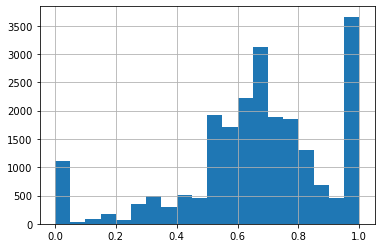

In [52]:
users.u_roc.hist(bins = 20)

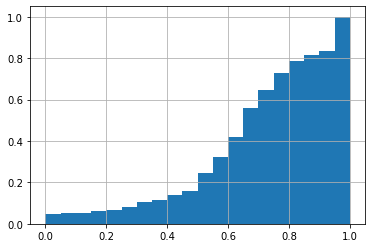

In [51]:
users.u_roc.hist(bins = 20, cumulative=True,density=1)

Compare distribution across user featurse

### Marketplace

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7efe0c746128>,
      dtype=object)

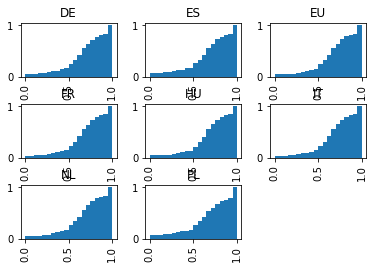

In [70]:
users_feat.u_roc.hist(by = users_feat.erstRegMarktplatz, bins = 20,cumulative=True,density=1)

### User-Group

In [74]:
users_feat.groupby('userklasse').userid.count()

userklasse
FreeD                 34
FreqBuyer           2508
HyFreqBuyer          397
PPBuyer              106
PPFreqBuyer          267
PPHyFreqBuyer        171
PPinactiveBuyer      185
PremiumPro           229
admin                 39
basic              20624
buyer               2035
inactiveBasic        276
inactiveBuyer       2977
inactiveProfi        230
inactiveStarter       66
member2               45
starter             3556
vendor               121
Name: userid, dtype: int64

Group categories together

In [96]:
userkl_grouped = []
for i in range(len(users_feat)):
    if (users_feat.userklasse[i] == 'FreeD' or users_feat.userklasse[i] == 'PremiumPro' or 
        users_feat.userklasse[i] == 'basic' or users_feat.userklasse[i] == 'member2'):
        userkl_grouped.append('basic')
    elif (users_feat.userklasse[i] == 'FreqBuyer' or users_feat.userklasse[i] == 'HyFreqBuyer' or  
          users_feat.userklasse[i] == 'PPFreqBuyer' or users_feat.userklasse[i] == 'PPHyFreqBuyer'):
        userkl_grouped.append('FreqBuyer')
    elif (users_feat.userklasse[i] == 'buyer' or  users_feat.userklasse[i] == 'PPinactiveBuyer' or
          users_feat.userklasse[i] == 'PPBuyer' or users_feat.userklasse[i] == 'inactiveBuyer'):
        userkl_grouped.append('buyer')
    elif (users_feat.userklasse[i] == 'inactiveBasic' or  
          users_feat.userklasse[i] == 'inactiveProfi' or
          users_feat.userklasse[i] == 'inactiveStarter'):
          userkl_grouped.append('inactive')
    elif (users_feat.userklasse[i] == 'starter'):
          userkl_grouped.append('starter')
    else:
        userkl_grouped.append('non_target')

In [97]:
len(userkl_grouped)

33867

In [98]:
users_feat['userklasse_grouped'] = userkl_grouped

In [115]:
users_feat.groupby('userklasse_grouped').userid.count()

userklasse_grouped
FreqBuyer      3343
basic         20932
buyer          5303
inactive        572
non_target      161
starter        3556
Name: userid, dtype: int64

In [135]:
users_feat.groupby('userklasse_grouped').clicks.mean()

userklasse_grouped
FreqBuyer     156.065809
basic          19.660950
buyer          41.154252
inactive       11.540210
non_target     76.645963
starter        22.739033
Name: clicks, dtype: float64

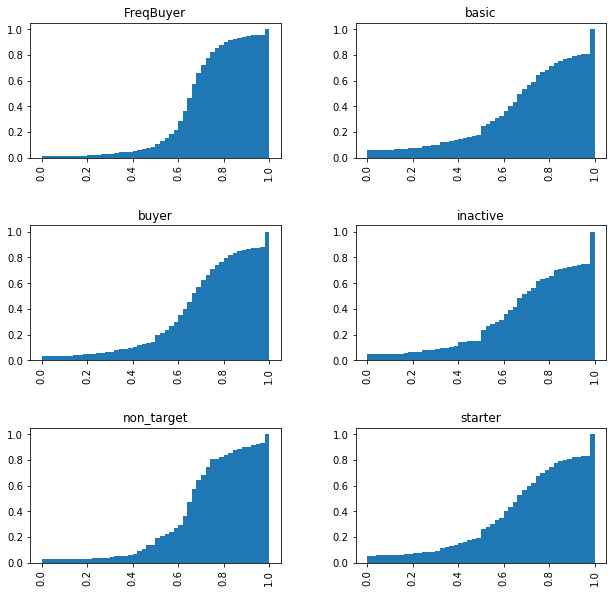

In [132]:
plot = users_feat.u_roc.hist(by = users_feat.userklasse_grouped, bins = 50,  cumulative=True,density=1, figsize  = (10,10))

filter for users:

In [134]:
users_feat[users_feat.clicks > 10].groupby('userklasse_grouped').u_roc.mean()

userklasse_grouped
FreqBuyer     0.661298
basic         0.663893
buyer         0.659611
inactive      0.674981
non_target    0.666072
starter       0.648915
Name: u_roc, dtype: float64

In [128]:
users_feat[users_feat.u_roc == 1].clicks.mean()

4.435825105782793

### UROC@M

Calculate UROC@M and compare the average at different values in Graph, M is max - so cutoff value, doesn't matter if user only has less

In [173]:
lists = {}
lists['all_user_roc_5'] = []
lists['all_user_roc_10'] = []
lists['all_user_roc_15'] = []
lists['all_user_roc_20'] = []

In [174]:
for u in users.userid.values.tolist(): 
    # user clicks
    data_u = results[results.userid == u].reset_index(drop=True)
    for k in [5, 10, 15, 20]:
        data_u_top = data_u.sort_values('y_pred', ascending = False)[:k]
        # aurco
        if len(data_u_top.y_true.unique()) > 1:
            roc = roc_auc_score(data_u_top.y_true, data_u_top.y_pred)
        else:
            roc = None
        k_name = 'all_user_roc_' + str(k)
        lists[k_name].append(roc)

Evaluate: Average per M

In [178]:
len(lists['all_user_roc_5'])

33867

In [179]:
all_roc_clean_5 = [x for x in lists['all_user_roc_5'] if not pd.isnull(x)]
user_roc_5 = sum(all_roc_clean_5) / len(all_roc_clean_5)

In [180]:
user_roc_5

0.5965776044442274

In [181]:
all_roc_clean_10 = [x for x in lists['all_user_roc_10'] if not pd.isnull(x)]
user_roc_10 = sum(all_roc_clean_10) / len(all_roc_clean_10)
user_roc_10

0.6174658027512235

In [182]:
all_roc_clean_15 = [x for x in lists['all_user_roc_15'] if not pd.isnull(x)]
user_roc_15 = sum(all_roc_clean_15) / len(all_roc_clean_15)
user_roc_15

0.6267289553672825

In [183]:
all_roc_clean_20 = [x for x in lists['all_user_roc_20'] if not pd.isnull(x)]
user_roc_20 = sum(all_roc_clean_20) / len(all_roc_clean_20)
user_roc_20

0.6331976470065621

In [214]:
users['u_roc_5'] = lists['all_user_roc_5']
users['u_roc_10'] = lists['all_user_roc_10']
users['u_roc_15'] = lists['all_user_roc_15']
users['u_roc_20'] = lists['all_user_roc_20']

In [216]:
users.to_pickle(pre_ev + "05_1_test_user_results_new_extended.pkl")

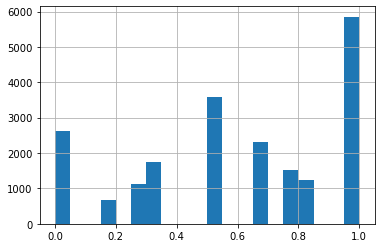

In [211]:
users['u_roc_5'].hist(bins = 20)

Graph to display results

In [187]:
all_uroc_scores = [user_roc_5, user_roc_10, user_roc_15, user_roc_20]

In [188]:
all_uroc_scores

[0.5965776044442274,
 0.6174658027512235,
 0.6267289553672825,
 0.6331976470065621]

In [228]:
M = ['5','10','15','20']

In [229]:
from matplotlib import pyplot as plt

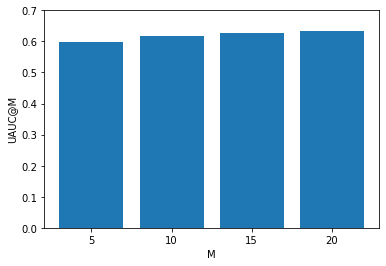

In [231]:
plt.bar(M, all_uroc_scores)
#plt.title('UAUC@M for different list length')
plt.ylabel('UAUC@M')
plt.xlabel('M')
plt.ylim(0,0.7)
plt.show()

### Evaluate Precision@M per User

In [217]:
avg_precision = np.mean(users.prec)
avg_precision

0.49470961801465113

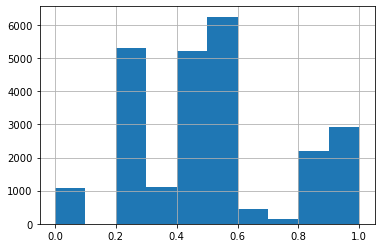

In [218]:
users.prec.hist()

In [219]:
users[pd.isna(users.u_roc) == False].prec.mean() # is a little overflattet now, because of some that are only 1

0.44452581908036737

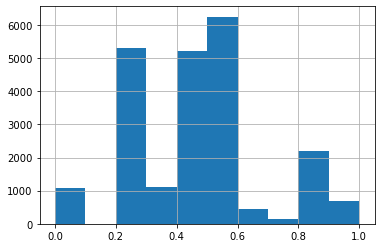

In [220]:
users[pd.isna(users.u_roc) == False].prec.hist()

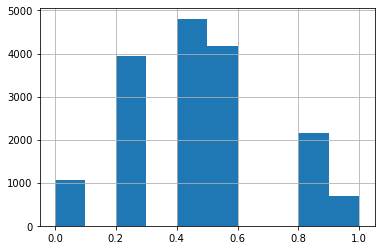

In [221]:
users[users.clicks > 5].prec.hist()

In [222]:
np.mean(users[users.clicks > 5].prec)

0.45303965803847074

### Evaluate Recall@M per User

In [223]:
avg_recall = np.mean(users.recall)
avg_recall

0.5970207058490113

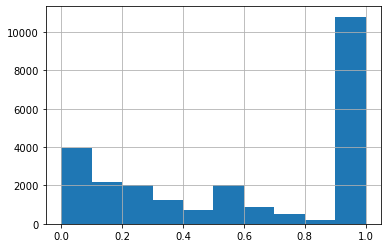

In [224]:
users.recall.hist()

In [225]:
users[users.clicks > 5].recall.mean() # is a little overflatted with users that have less than 5 

0.41105786724561333

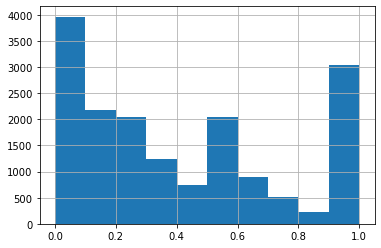

In [226]:
users[users.clicks > 5].recall.hist()

## Compare Scores of known vs. unknown users

In [23]:
import scipy

In [10]:
users_tr = pd.read_sql('SELECT DISTINCT userid from target_training_enc', engine).values
items_tr = pd.read_sql('SELECT DISTINCT anbieter_artikelnummer from target_training_enc', engine).values

In [11]:
users = pd.read_pickle(pre_ev + "05_1_test_user_results_new_extended.pkl")

In [12]:
users.head()

,userid,clicks,picks,u_roc,prec,recall,u_roc_5,u_roc_10,u_roc_15,u_roc_20
0,0,436,295.0,0.587835,0.6,0.010169,0.666667,0.458333,0.360000,0.240000
1,100099,18,7.0,0.636364,0.6,0.428571,0.166667,0.520000,0.648148,0.636364
2,100134,85,21.0,0.728423,0.4,0.095238,0.500000,0.250000,0.482143,0.510000
3,100178,1,1.0,NaN,1.0,1.000000,NaN,NaN,NaN,NaN
4,100561,20,2.0,0.861111,0.4,1.000000,0.166667,0.687500,0.807692,0.861111


In [13]:
users_tr_df = pd.DataFrame(users_tr)

In [14]:
users_j = pd.merge(users, users_tr_df, how = 'left',left_on = 'userid', right_on = 0)

In [21]:
users_j_notna = users_j[pd.notna(users_j.u_roc)]

Average UROC for users that are not in the training data

In [15]:
np.mean(users_j[pd.isna(users_j[0])].u_roc)

0.6615978316713353

In [16]:
len(users_j[pd.isna(users_j[0])].u_roc)

11532

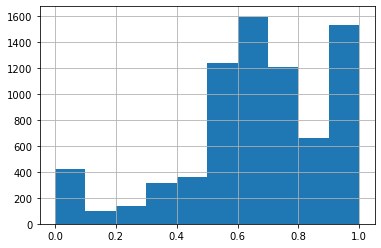

In [17]:
users_j[pd.isna(users_j[0])].u_roc.hist()

Average UROC for users that are in the training data

In [18]:
np.mean(users_j[pd.isna(users_j[0]) == False].u_roc)

0.6640347619173441

In [19]:
len(users_j[pd.isna(users_j[0]) == False].u_roc)

22335

In [20]:
sum(users_j.picks)/sum(users_j.clicks)

0.2854074080585753

Test significance of results

In [24]:
scipy.stats.ttest_ind(users_j_notna[pd.isna(users_j_notna[0]) == False].u_roc, users_j_notna[pd.isna(users_j_notna[0])].u_roc)

Ttest_indResult(statistic=0.7021940234146907, pvalue=0.48256547144275874)

# More Detailed Analysis for Choosen Model

# Per User Analysis

Many user don't have many clicks - therefore, its not a true @k

In [81]:
users.clicks.describe()

count    33867.000000
mean        36.947855
std        387.207777
min          1.000000
25%          2.000000
50%          6.000000
75%         21.000000
max      67488.000000
Name: clicks, dtype: float64

Filter unusual Users

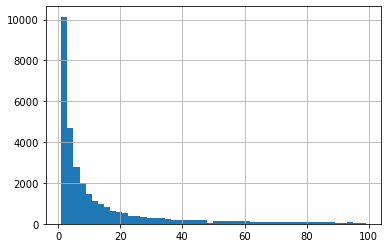

In [83]:
users[users.clicks < 100].clicks.hist(bins = 50)

In [86]:
user_results_fil = users[users.clicks < 100]

## Analye the relationship between clicks in test data and achieved score

In [87]:
from scipy import stats

In [88]:
grouped = user_results_fil.groupby('clicks').mean()
#grouped = user_results.groupby('clicks').mean()

In [89]:
grouped = grouped.reset_index()

u_roc does not depend on the number of test clicks - makes sense!

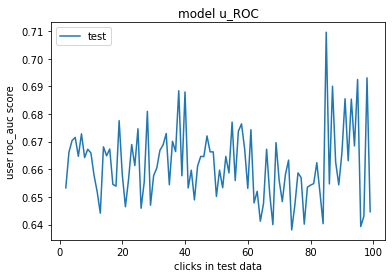

In [90]:
plt.plot(grouped.clicks, grouped.u_roc)
plt.title('model u_ROC')
plt.ylabel('user roc_auc score')
plt.xlabel('clicks in test data')
plt.legend(['test'], loc='upper left')
plt.show()

Precision and Recall get higher the more clicks are ranked - makes sense !

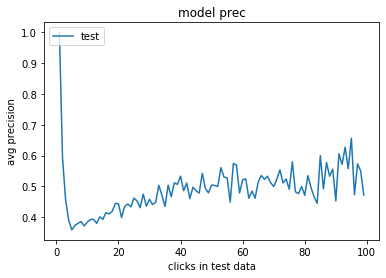

In [92]:
plt.plot(grouped.clicks, grouped.prec)
plt.title('model prec')
plt.ylabel('avg precision')
plt.xlabel('clicks in test data')
plt.legend(['test'], loc='upper left')
plt.show()

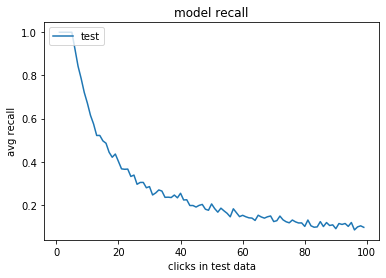

In [93]:
plt.plot(grouped.clicks, grouped.recall)
plt.title('model recall')
plt.ylabel('avg recall')
plt.xlabel('clicks in test data')
plt.legend(['test'], loc='upper left')
plt.show()

## Analyze the relationship between clicks in training data and achieved Score

In [56]:
clicks_train = pd.read_sql ( ''' SELECT te.userid, tr.clicks 
        FROM target_testing_enc as te
        LEFT JOIN (select userid, count(*) as clicks 
        from target_training_enc group by userID) as tr 
        on te.userid = tr.userid''', engine)

In [59]:
clicks_train = clicks_train.drop_duplicates('userid', keep = "last")
len(clicks_train)

33867

In [61]:
filter_train = pd.read_sql("SELECT * from training_user_filter", engine)
filter_train['filter'] = 1

In [62]:
filter_train.head()

,userid,filter
0,1559225,1
1,1608456,1
2,1657316,1
3,1575782,1
4,1587975,1


In [63]:
clicks_train_filter = clicks_train.merge(filter_train, how = 'left', on = "userid")

In [64]:
clicks_train_filter

,userid,clicks,filter
0,1631492,3.0,NaN
1,731970,5.0,NaN
2,1678497,NaN,NaN
3,1672095,3.0,NaN
4,1678496,NaN,NaN
...,...,...,...
33862,729176,3603.0,NaN
33863,1669797,25.0,NaN
33864,1592686,4737.0,NaN
33865,1664390,1787.0,NaN


In [70]:
clicks_train_filter = clicks_train_filter.assign(clicks_train = np.where (clicks_train_filter['filter'].isnull(), clicks_train_filter.clicks, 0))

In [72]:
clicks_train_filter = clicks_train_filter.fillna(0)

In [75]:
clicks_train_filter.drop(['filter', 'clicks'], axis = 1, inplace = True)

In [76]:
clicks_train_filter.head()

,userid,clicks_train
0,1631492,3.0
1,731970,5.0
2,1678497,0.0
3,1672095,3.0
4,1678496,0.0


In [258]:
user_results_1 = user_results_fil.merge(clicks_train_filter, how = 'left', on = "userid")

In [259]:
grouped_1 = user_results_1.groupby('clicks_train').mean()

In [260]:
grouped_1

,clicks,u_roc,prec,recall,precision_n,recall_n
clicks_train,,,,,,
0.0,11.936434,0.660926,0.181940,0.159370,0.325673,0.494154
1.0,5.074074,0.664918,0.111111,0.067901,0.277160,0.320988
2.0,6.191111,0.655502,0.113506,0.095679,0.266568,0.347531
3.0,6.220641,0.708872,0.124466,0.092764,0.294336,0.397746
4.0,6.888446,0.663850,0.157205,0.124967,0.279349,0.387649
...,...,...,...,...,...,...
6780.0,85.000000,0.543077,0.666667,1.000000,0.400000,1.000000
6808.0,36.000000,0.548611,0.000000,0.000000,0.200000,1.000000
8797.0,8.000000,0.857143,0.000000,0.000000,0.500000,1.000000


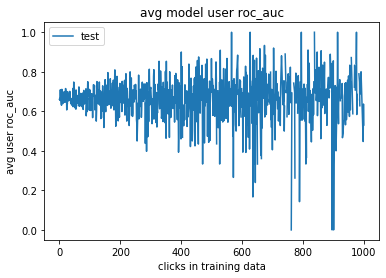

In [298]:
# index = clicks in training data
plt.plot(grouped_1[grouped_1.index.values < 1000].index, grouped_1[grouped_1.index < 1000].u_roc) 
plt.title('avg model user roc_auc')
plt.ylabel('avg user roc_auc')
plt.xlabel('clicks in training data')
plt.legend(['test'], loc='upper left')
plt.show()

Quote Constant - more variance when more clicks in training data - maybe slight overfitting there in some cases - also positive examples

## Analyze relationship between clicks in profile

In [98]:
train_anbieter_user = pd.read_sql("SELECT [index], anbieterid_enc_user from target_testing_enc", engine)

In [ ]:
train_anbieter_user = evaluate.unpickle_data(train_anbieter_user)

In [99]:
train_anbieter_user.head()

,index,anbieterid_enc_user
0,128300,"[63, 63, 63, 487]"
1,128301,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, ..."
2,128302,"[2, 3, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31,..."
3,128303,"[14, 14, 61, 70, 70, 116, 123, 123, 123, 123, ..."
4,128304,"[63, 63, 63, 487]"


In [99]:
train_anbieter_user['count'] = [len(train_anbieter_user.anbieterid_enc_user[i]) for i in range(len(train_anbieter_user))]

In [267]:
def custom_round(x, base=5):
    return int(base * round(float(x)/base))

might fail if not both classes in test data...

In [268]:
train_anbieter_user['count_rd'] = train_anbieter_user['count'].apply(lambda x: custom_round(x, base=5))

In [274]:
results_2 = pd.merge(results, train_anbieter_user, how = 'left', on = "index")

In [276]:
results_2

,index,userid,y_true,y_pred,y_pred_dec,anbieterid_enc_user,count,count_rd
0,118334,793955,0.0,0.423723,1,"[31, 63, 63, 63, 63, 63, 63, 81, 81, 81, 81, 8...",200,200
1,118335,1630984,1.0,0.239896,0,"[5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 137, 137, 137, ...",200,200
2,118336,1678111,0.0,0.088764,0,"[5, 5, 5, 5, 5, 36, 90, 90, 90, 90, 125, 125, ...",107,105
3,118337,793955,0.0,0.290778,0,"[31, 63, 63, 63, 63, 63, 63, 81, 81, 81, 81, 8...",200,200
4,118338,1677245,0.0,0.187185,0,"[2, 2, 2, 2, 2, 2, 2, 2, 6, 31, 31, 31, 31, 31...",147,145
...,...,...,...,...,...,...,...,...
1251308,118329,1678111,0.0,0.132147,0,"[5, 5, 5, 5, 5, 36, 90, 90, 90, 90, 125, 125, ...",107,105
1251309,118330,623019,0.0,0.168387,0,"[5, 5, 5, 5, 31, 61, 116, 116, 125, 125, 176, ...",136,135
1251310,118331,793955,0.0,0.276602,0,"[31, 63, 63, 63, 63, 63, 63, 81, 81, 81, 81, 8...",200,200
1251311,118332,863672,1.0,0.443585,1,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...",200,200


In [277]:
grouped_2 = results_2.groupby('count_rd').apply(lambda x: roc_auc_score(x.y_true, x.y_pred))

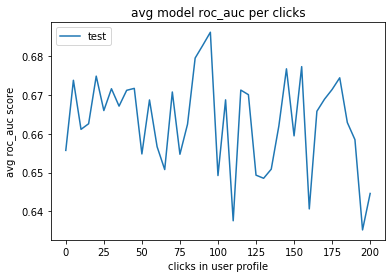

In [295]:
plt.plot(grouped_2.index, grouped_2)
plt.title('avg model roc_auc per clicks')
plt.ylabel('avg roc_auc score')
plt.xlabel('clicks in user profile')
plt.legend(['test'], loc='upper left')
plt.show()

In [292]:
print('User Roc is highest with '+str(round(max(grouped_2), 2))+ ' at ' + str(round(grouped_2[grouped_2 == max(grouped_2)].index[0])) + ' clicks in user history')

User Roc is highest with 0.69 at 95 clicks in user history


## Compare to Baseline and Test Significance of Results

In [27]:
users7 = pd.read_pickle(pre_ev + "07_1_test_user_results_new_extended.pkl")

In [29]:
scipy.stats.ttest_ind(users.u_roc, users7.u_roc, nan_policy="omit")

Ttest_indResult(statistic=-9.909431813307348, pvalue=4.001620627505193e-23)

In [34]:
scipy.stats.ttest_ind(users.u_roc_5, users7.u_roc_5, nan_policy="omit")

Ttest_indResult(statistic=-14.523802416863761, pvalue=1.1266926403255523e-47)